In [1]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.bitfinex_kaggle import *
from talib.abstract import *

In [2]:
def strategy(df, config):
    mean_volume = df["volume"].rolling(int(config["mean_volume_period"])).mean().shift(1)
    volume_signal = (df["volume"] / mean_volume) > config["volume_times"]
    
    returns = df["close"].pct_change(int(config["return_period"]))
    return_signal = ((returns == returns.rolling(int(config["return_signal_period"])).max()).rolling(int(config["any_return_period"])).max() == 1)
        
    breakout_signal = df["high"] > df["high"].rolling(int(config["time_cut"] // 2)).max().shift(1)
    breakout_signal_short = df["low"] < df["low"].rolling(int(config["time_cut"] // 2)).min().shift(1)
    
    ma = df["close"].rolling(int(config["ma_period"])).mean()
    ma_signal = ma.diff() > 0
    
    df["enter_long"] = return_signal & volume_signal & ma_signal & breakout_signal
    # df["enter_short"] = short_return_signal & volume_signal & (ma_signal == 0) & breakout_signal_short
    
    df["bet"] = np.clip(0.05 / df["close"].pct_change().rolling(200).std(), 0.1, 1) * 2
    
    df["time_cut"] = config["time_cut"]
    df["stop_loss"] = config["stop_loss"] / df["bet"]
    df["take_profit"] = config["take_profit"]
    df["trade_cost"] = 0.001
    

    
    return df

In [3]:
def backtest(config, ticker):
    data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

In [18]:
DEFAULT_CONFIG = {'return_signal_period': 24,
 'ma_period': 48,
 'mean_volume_period': 12,
 'return_period': 6,
 'any_return_period': 3,
 'time_cut': 24,
 'stop_loss': 0.05,
 'take_profit': 0.1,
 'volume_times': 3}

backtest completed in 0.05747842788696289 seconds


                           Strategy     Benchmark
-------------------------  -----------  -----------
Start Period               2016-03-18   2016-03-18
End Period                 2021-05-18   2021-05-18
Risk-Free Rate             0.0%         0.0%
Time in Market             31.0%        97.0%

Cumulative Return          103,620.61%  31,191.55%
CAGR%                      283.14%      203.87%

Sharpe                     1.75         1.31
Sortino                    4.13         2.07
Sortino/√2                 2.92         1.46

Max Drawdown               -37.71%      -93.85%
Longest DD Days            207          1101
Volatility (ann.)          63.86%       87.76%
R^2                        0.17         0.17
Calmar                     7.51         2.17
Skew                       3.61         0.38
Kurtosis                   23.4         5.56

Expected Daily %           0.37%        0.3%
Expected Monthly %         11.65%       9.55%
Expected Yearly %          218.16%      160.56%
Kelly Cr

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-10-22,2016-12-26,2017-01-04,74,-37.705879,-34.153458
2,2019-01-05,2019-02-05,2019-02-18,44,-35.385434,-35.074817
3,2019-10-30,2020-01-31,2020-03-19,141,-33.041048,-30.961606
4,2017-11-24,2018-01-21,2018-06-19,207,-30.873644,-29.405919
5,2020-09-02,2020-11-16,2020-12-16,105,-29.186458,-25.271808


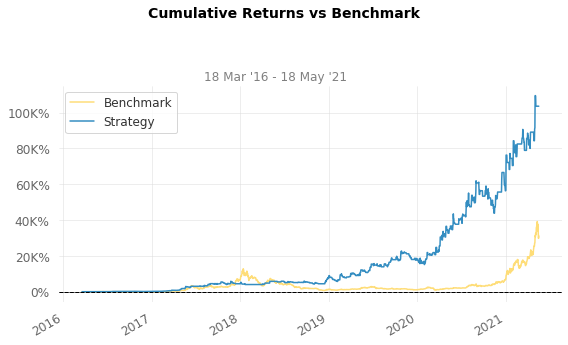

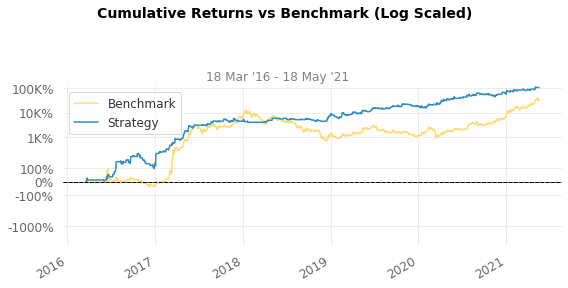

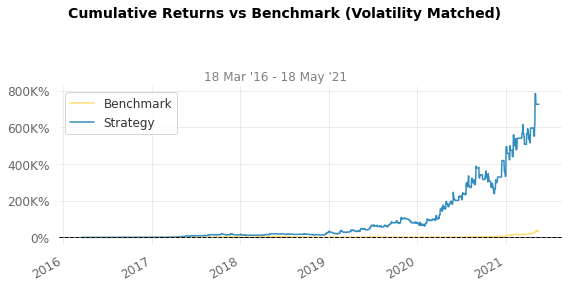

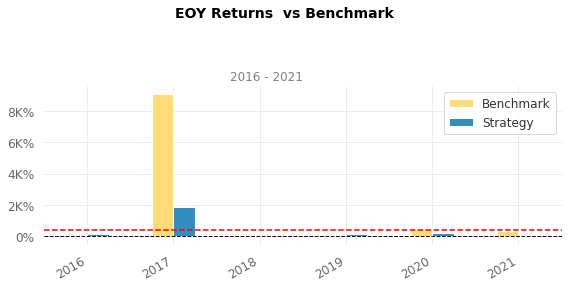

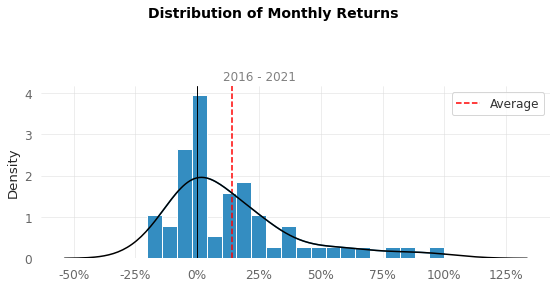

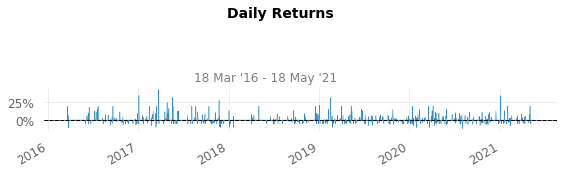

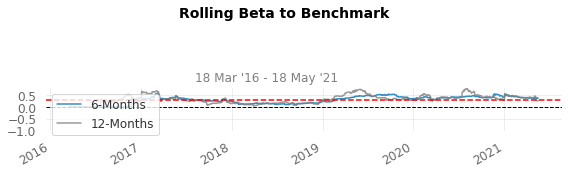

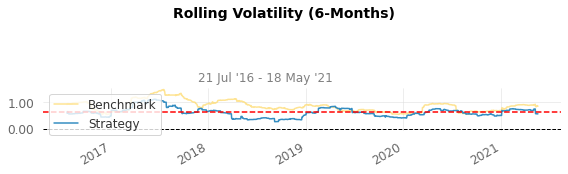

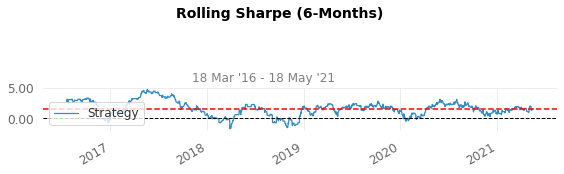

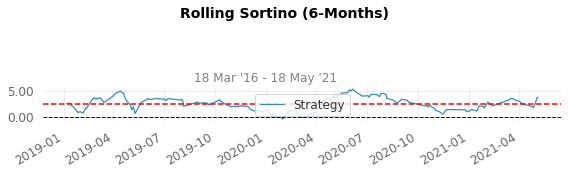

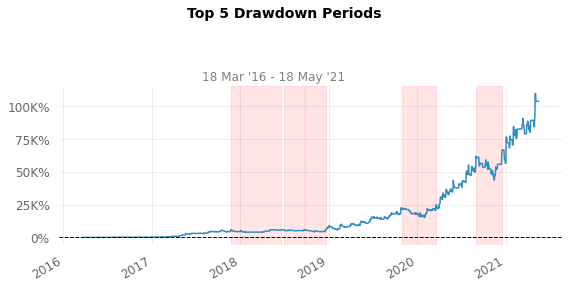

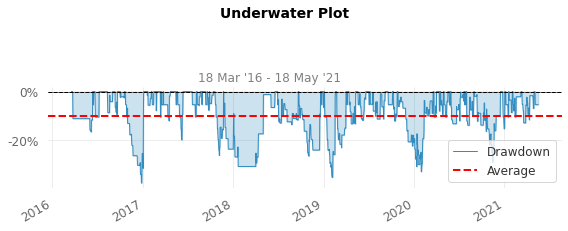

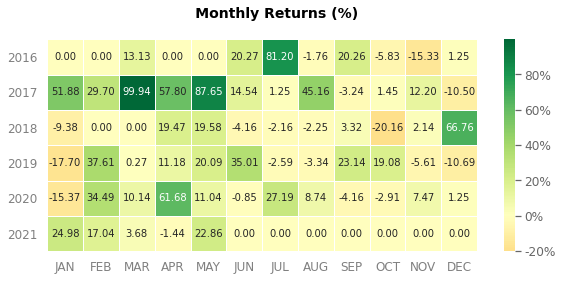

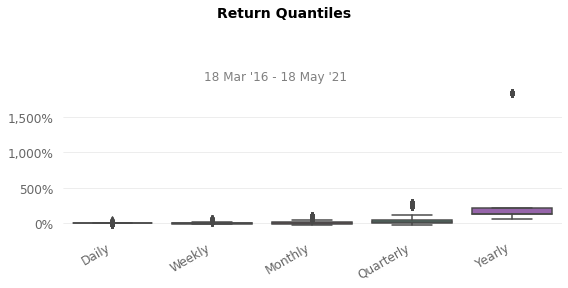

In [19]:
backtest(DEFAULT_CONFIG, "ETHUSD")

backtest completed in 0.09179019927978516 seconds


                           Strategy     Benchmark
-------------------------  -----------  -----------
Start Period               2013-04-09   2013-04-09
End Period                 2021-05-18   2021-05-18
Risk-Free Rate             0.0%         0.0%
Time in Market             34.0%        96.0%

Cumulative Return          432,333.62%  18,597.53%
CAGR%                      180.67%      90.56%

Sharpe                     1.77         0.99
Sortino                    3.8          1.48
Sortino/√2                 2.69         1.04

Max Drawdown               -48.43%      -84.25%
Longest DD Days            227          1126
Volatility (ann.)          45.98%       69.36%
R^2                        0.15         0.15
Calmar                     3.73         1.07
Skew                       3.06         0.14
Kurtosis                   20.58        10.5

Expected Daily %           0.28%        0.18%
Expected Monthly %         8.92%        5.48%
Expected Yearly %          153.51%      78.82%
Kelly Cri

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-08-06,2019-10-19,2020-03-20,227,-48.434567,-46.886999
2,2014-01-20,2014-05-17,2014-05-30,130,-32.723806,-32.494855
3,2013-04-24,2013-07-10,2013-08-14,112,-30.176397,-24.784576
4,2020-08-10,2020-11-04,2020-12-17,129,-27.773840,-22.877577
5,2016-07-03,2016-09-02,2016-12-27,177,-23.199810,-21.103531


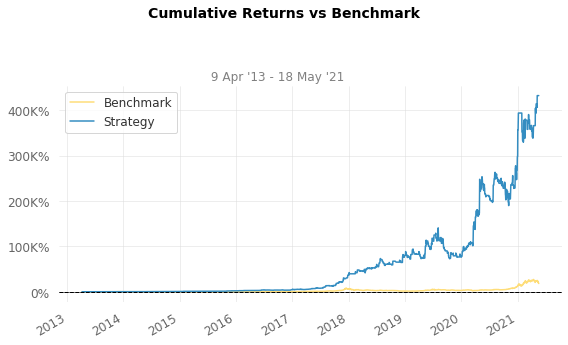

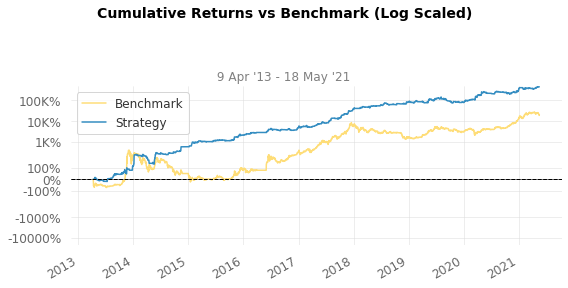

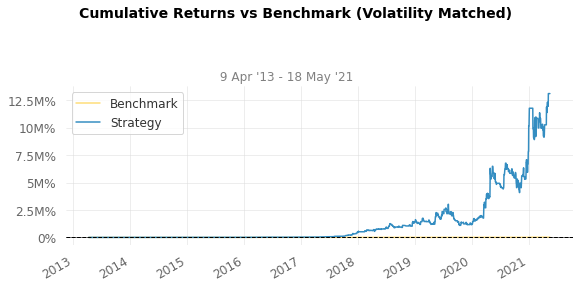

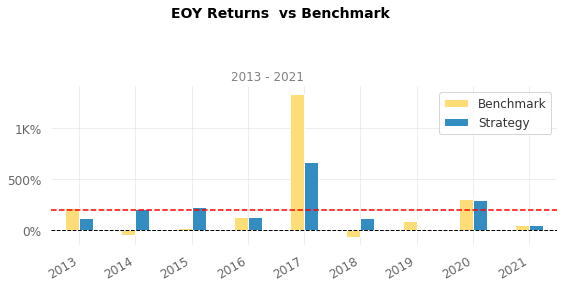

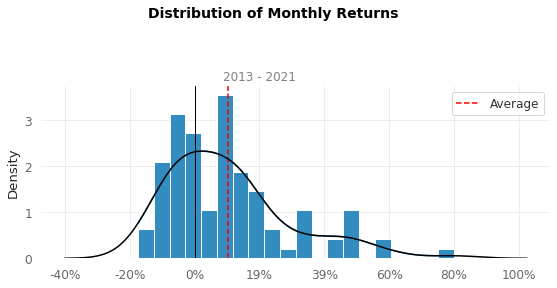

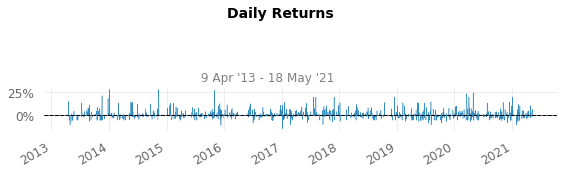

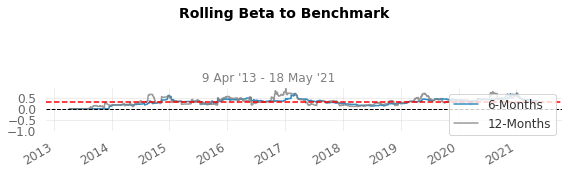

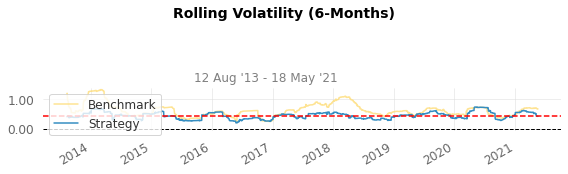

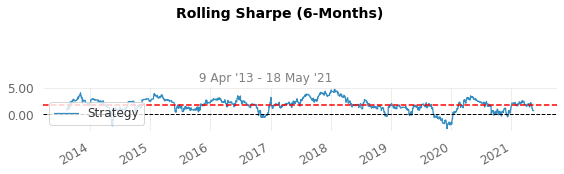

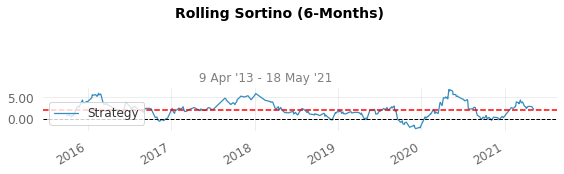

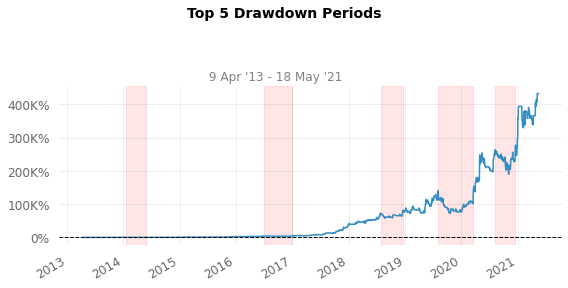

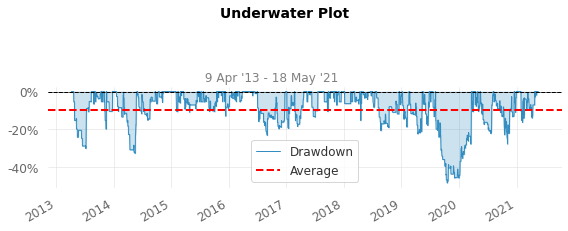

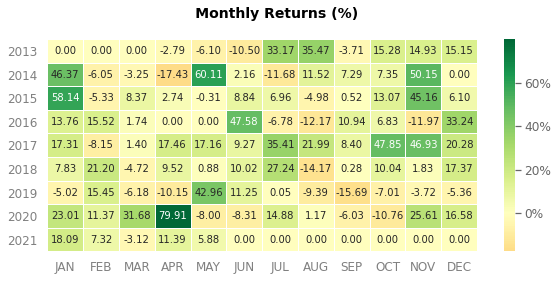

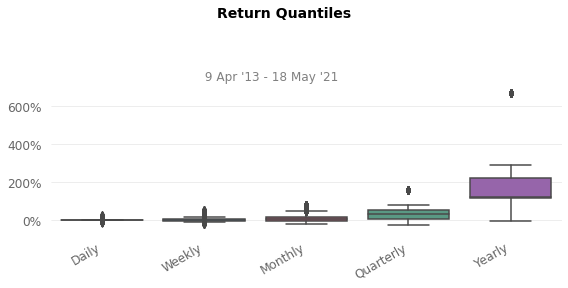

In [20]:
backtest(DEFAULT_CONFIG, "BTCUSD")

In [7]:
import ray
from ray import tune
def optimizer(config, df):
    df = df.copy()
    order_df, port_df = run_backtest_df(strategy(df, config))
    tune.report(sortino=qs.stats.sortino(port_df["portfolio_value"].resample("1D").last()))

def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "return_signal_period" : tune.grid_search([12, 24, 48]),
            "ma_period" : tune.grid_search([12, 24, 48]),
            "mean_volume_period" : tune.grid_search([12, 24, 48]),
            "return_period" : tune.grid_search([6, 12, 24]),
            "any_return_period" : 3,
            "time_cut" : tune.grid_search([12, 24]),
            "stop_loss" : tune.grid_search([0.03, 0.05]),
            "take_profit" : tune.grid_search([0.5, 0.1, 0.15]),
            "ma_period" : tune.grid_search([12, 24, 48]),
            "volume_times" : tune.grid_search([3, 5, 7]),
        },
        local_dir="./ray_results",
    )
    return result

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [8]:
ray.init()

2021-05-25 23:59:39,115	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:6379',
 'object_store_address': '/tmp/ray/session_2021-05-25_23-59-38_052616_3221/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-25_23-59-38_052616_3221/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-25_23-59-38_052616_3221',
 'metrics_export_port': 50182,
 'node_id': '2556cecaf15222532a14a4adf3d70c34a3410be1f851a80beb5b3d70'}

In [10]:
data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", "BTCUSD")
data = data.backtest.add_defaults()

In [11]:
data = data[:int(data.index.__len__() * 0.7)]

In [ ]:
result = optimize(data)

In [13]:
result.get_best_config("sortino", mode="max")

{'return_signal_period': 24,
 'ma_period': 48,
 'mean_volume_period': 12,
 'return_period': 6,
 'any_return_period': 3,
 'time_cut': 24,
 'stop_loss': 0.05,
 'take_profit': 0.15,
 'volume_times': 5}